## pyDGSA tutorial (detailed version)

This analytic example consists of 200 model simulations, each of which has 4 parameters and 2 responses. The model parameters are latin hypercube sampled values between 0 and 1:

| v | w | x | y | z |
|------|------|------|------|------|
|0.7975|0.5725|0.5475|0.0675|0.6225|
|0.8175|0.5125|0.3325|0.1325|0.6175|
|0.2075|0.5925|0.7475|0.3625|0.4625|
| .... | .... | .... | .... | .... |

The responses are calculated as:

| Resp. 1 | Resp. 2 | Resp. 3         | Resp. 4 |
|---|---|-----------------|---------|
| z | abs(x * (y - 1)) | sqrt(min(x, y)) | sqrt(z) |

Clearly, `z` should be the most sensitive parameter, followed by `x` and `y`. This is a modified version of the problem presented in <a href="https:doi.org/10.1007/s11004-014-9530-5">Fenwick et al. (2014)</a>, with two extra parameters (`v` and `w`) and two extra response categories.

In [1]:
import numpy as np
import pandas as pd
import os 

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA


In [3]:
folder_path = '../../CCUS/data/GlobalSA_exp1/'

dfexp = pd.read_csv(os.path.join(folder_path, 'exp_design_runall_sample1.csv'))
allnpynames = os.listdir(os.path.join(folder_path, 'simfiles_runall_sample1', 'rst_npy'))
caseid = np.sort([int(x.split('_')[0][4:]) for x in allnpynames])
dfexpX = dfexp[dfexp['caseid'].isin(caseid)]

In [4]:
num_sample, _ = dfexpX.shape

allrst_max = np.zeros((num_sample, 1))
allrst_3D = np.zeros((num_sample, 33, 33, 31))

for ii, cid in enumerate(caseid):
    xx = np.load(os.path.join(folder_path, 'simfiles_runall_sample1', 'rst_npy', f'case{cid}_VERDSPLGEO.npy'))
    num_time = xx.shape[-1]
    allrst_max[ii] = np.max(xx[:,:,0,:])
    allrst_3D[ii,:,:,0:num_time-2] = xx[:,:,0,:-2]

In [8]:
allrst_3D.shape

(79, 33, 33, 31)

## Read the pre-processed data
- runall sample 1 case
- LHS205 case
- 196 samples in total

In [2]:
folder_path = '../../CCUS/data/GlobalSA_exp1/'

load_dfall = pd.read_csv(os.path.join(folder_path, 'DGSA_exp1.csv'))
load_rst_npy = np.load(os.path.join(folder_path, 'DGSA_exp1.npy'))

In [4]:
num_sample = load_rst_npy.shape[0]

## For 3D case

- PCA

Number of components explaining 99% variance: 5


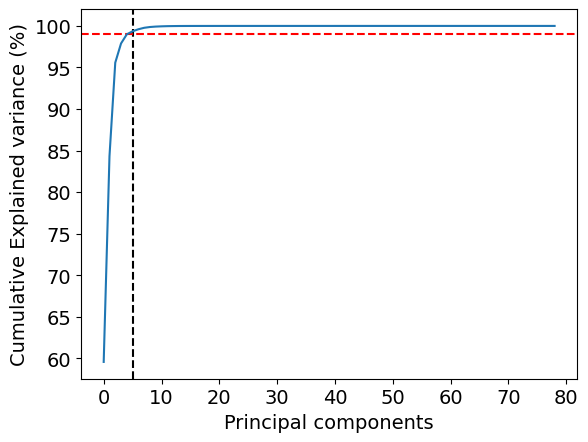

In [72]:
image = allrst_3D.reshape(num_sample,-1)


pca = PCA()
pca.fit(image)

# Getting the cumulative variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>99)
print("Number of components explaining 99% variance: "+ str(k))
#print("\n")


# plt.figure(figsize=[10,5])
# plt.title('Cumulative Explained Variance explained by component')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Cumulative Explained variance (%)', fontsize=14)
plt.xlabel('Principal components', fontsize=14)
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=99, color="r", linestyle="--")
ax = plt.plot(var_cumu)

#### Test: using PCs to reconstruct raw images

In [73]:
ipca = IncrementalPCA(n_components=k)
myPCs = ipca.fit_transform(image)
image_recon = ipca.inverse_transform(ipca.fit_transform(image))


Save PCs if needed

In [ ]:
# np.save('../pyDGSA/data/video_PCs.npy', myPCs)

The L2 error of demo case10 after 10 of injection is: 0.01681858991359947 ft


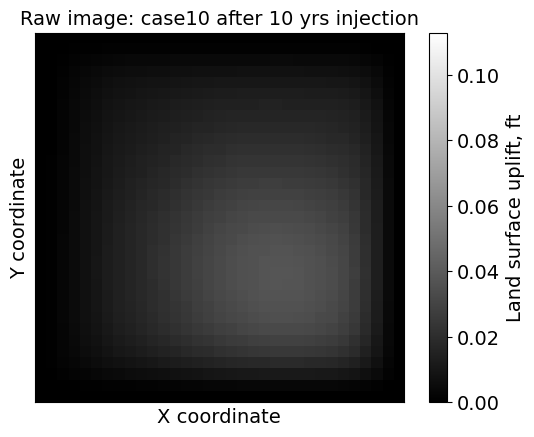

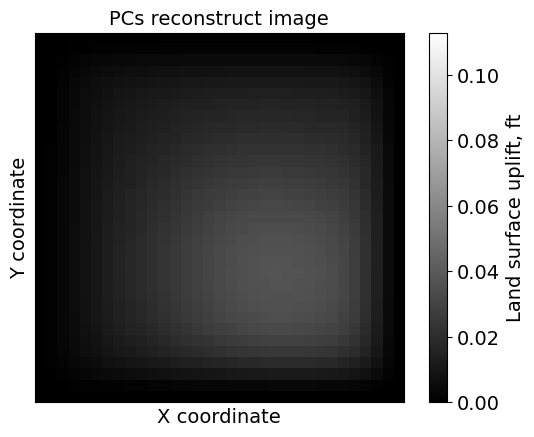

In [68]:
demo_idx = 10
demo_time = 10

l2_err = np.sqrt(np.sum((image.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time] - image_recon.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time])**2))
print(f'The L2 error of demo case{demo_idx} after {demo_time} of injection is: {l2_err} ft')

# Plotting the reconstructed image
min_val=min(np.min(image.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time]), np.min(image_recon.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time]))
max_val=max(np.max(image.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time]), np.max(image_recon.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time]))

fig, ax = plt.subplots()
plt.imshow(image.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time],cmap = plt.cm.gray, vmin=0, vmax=3*max_val)
plt.xlabel('X coordinate', fontsize=14)
plt.ylabel('Y coordinate', fontsize=14)
plt.title(f'Raw image: case{demo_idx} after {demo_time} yrs injection', fontsize=14)
cbar = plt.colorbar()
cbar.set_label("Land surface uplift, ft", fontsize=14)
cbar.ax.tick_params(labelsize=14) 
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.show()

fig, ax = plt.subplots()
plt.imshow(image_recon.reshape(num_sample, 33, 33, -1)[demo_idx,:,:,demo_time],cmap = plt.cm.gray, vmin=0, vmax=3*max_val)
plt.xlabel('X coordinate', fontsize=14)
plt.ylabel('Y coordinate', fontsize=14)
plt.title(f'PCs reconstruct image', fontsize=14)
cbar = plt.colorbar()
cbar.set_label("Land surface uplift, ft", fontsize=14)
cbar.ax.tick_params(labelsize=14) 
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.show()

## DGSA work

In [81]:

parameters = dfexpX.values[:,2:-1]
responses = myPCs

parameter_names = list(dfexpX.columns[2:-1])


In [77]:
# Now, calculate the euclidean distances between model responses
from scipy.spatial.distance import pdist, squareform

distances = pdist(responses, metric='euclidean')
distances = squareform(distances)

In [96]:
# Cluster the responses using KMedoids
from pyDGSA.cluster import KMedoids

n_clusters = 2
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels, medoids = clusterer.fit_predict(distances)

It's also easy to use a different clustering method, e.g.:
```python
from sklearn.cluster import KMeans

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels = clusterer.fit_predict(distances)
```

## Examples using `pyDGSA.dgsa`

Next, let's calculate the mean standardized  sensitivity using a specific alpha quantile (0.99 instead of 0.95) and a larger number of boots (5000 instead of 3000). Recall that the sensitivity is defined as $\frac{d}{d_{0.95}}$, so we are instead calculating $\frac{d}{d_{0.99}}$.

In [97]:
from pyDGSA.dgsa import dgsa

mean_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, quantile=0.99, 
                        n_boots=5000, confidence=True)
print(mean_sensitivity)

  0%|          | 0/5000 [00:00<?, ?it/s]

                   sensitivity  confidence
E_shale, psi          0.500574    0.228783
E_sand, psi           0.800725    0.345913
v_shale               0.268545    0.127491
v_sand                0.313206    0.123513
kvkh                  0.495034    0.191957
inj_rate, ft3/day     0.879023    0.415855
inj_hrzn, year        1.730525    0.723452


Instead of showing the mean sensitivity averaged across all clusters, it's also possible to return the standardized sensitivity for each individual cluster. The example below provides names for each cluster, assuming you know the unique characteristics that define each cluster.

In [98]:
# cluster_names = ['Low cluster', 'Medium cluster', 'High cluster']
cluster_names = [f'Cluster{i+1}' for i in range(n_clusters)]


cluster_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, 
                           output='cluster_avg', cluster_names=cluster_names)
print(cluster_sensitivity)

  0%|          | 0/3000 [00:00<?, ?it/s]

                   Cluster1  Cluster2
E_shale, psi       0.687776  0.614140
E_sand, psi        1.000000  1.010282
v_shale            0.343348  0.317732
v_sand             0.445727  0.425722
kvkh               0.603149  0.656902
inj_rate, ft3/day  1.205438  1.140576
inj_hrzn, year     2.374648  2.177288


## Examples using `pyDGSA.dgsa_interactions`

The pyDGSA package includes functionality for calcuating two-way parameter interactions. The fastest way to do so is to use all the default options.

In [99]:
from pyDGSA.dgsa import dgsa_interactions

mean_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                              parameter_names=parameter_names)
print(mean_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/2 [00:00<?, ?it/s]

                                   sensitivity
kvkh | inj_hrzn, year                 1.047443
E_sand, psi | E_shale, psi             1.04676
E_shale, psi | E_sand, psi             1.00031
inj_hrzn, year | v_sand               0.877519
inj_rate, ft3/day | E_sand, psi       0.837708
kvkh | inj_rate, ft3/day              0.792949
v_sand | inj_hrzn, year               0.777792
E_sand, psi | inj_hrzn, year          0.755816
E_sand, psi | kvkh                    0.736931
inj_hrzn, year | E_sand, psi          0.714564
E_sand, psi | inj_rate, ft3/day       0.702462
inj_rate, ft3/day | kvkh              0.601492
v_sand | kvkh                         0.593637
inj_rate, ft3/day | v_sand            0.577982
inj_hrzn, year | kvkh                 0.547817
kvkh | E_sand, psi                     0.54631
v_shale | kvkh                        0.544038
E_shale, psi | v_sand                 0.530887
v_shale | E_shale, psi                 0.50601
E_sand, psi | v_sand                  0.499132
v_sand | E_sh

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


Or, it's possible to specify interactions between only a few conditional parameters. For example, to calculate sensitivity when `x` and `y` are conditioned to one of 5 bins:

In [100]:
sens = dgsa_interactions(parameters, labels, 
                        #  cond_parameters=['depth','deviation','length', 'direction'], 
                         cond_parameters=parameter_names,
                         parameter_names=parameter_names, 
                         n_bins=5)
print(sens)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/2 [00:00<?, ?it/s]

                                   sensitivity
E_sand, psi | E_shale, psi            1.027821
E_shale, psi | E_sand, psi            1.008823
kvkh | inj_hrzn, year                 1.001693
inj_hrzn, year | v_sand               0.877519
inj_rate, ft3/day | E_sand, psi       0.844629
inj_hrzn, year | E_sand, psi          0.797798
kvkh | inj_rate, ft3/day               0.78103
v_sand | inj_hrzn, year               0.777792
E_sand, psi | inj_hrzn, year          0.739327
inj_hrzn, year | kvkh                 0.704242
E_sand, psi | inj_rate, ft3/day       0.701596
E_sand, psi | kvkh                    0.618312
inj_rate, ft3/day | v_sand            0.584174
inj_rate, ft3/day | kvkh              0.568138
kvkh | E_sand, psi                    0.549402
v_sand | kvkh                         0.534102
E_shale, psi | v_sand                 0.507844
v_shale | E_shale, psi                 0.50601
E_sand, psi | v_sand                  0.499811
v_sand | E_shale, psi                 0.495266
v_shale | kvk

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


The sensitivity values reported above are averaged over each cluster and bin. To get the standardized sensitivity on individual cluster/bin levels, specify the output format (`output='cluster_avg'` or `output='bin_avg'`). 

In [101]:
cluster_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                                 parameter_names=parameter_names,
                                                 cluster_names=cluster_names, 
                                                 output='cluster_avg')
print(cluster_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/2 [00:00<?, ?it/s]

                                    Cluster1  Cluster2
E_sand, psi | E_shale, psi          1.392058  0.683727
v_shale | E_shale, psi              0.407417  0.604603
v_sand | E_shale, psi                0.67241  0.318123
kvkh | E_shale, psi                 0.342252  0.162681
inj_rate, ft3/day | E_shale, psi    0.175472  0.498739
inj_hrzn, year | E_shale, psi       0.528139  0.333133
E_shale, psi | E_sand, psi          1.231374  0.786272
v_shale | E_sand, psi               0.099478  0.262936
v_sand | E_sand, psi                0.500158   0.19442
kvkh | E_sand, psi                   0.58688  0.508642
inj_rate, ft3/day | E_sand, psi     0.378953  1.302707
inj_hrzn, year | E_sand, psi        0.595794  0.833333
E_shale, psi | v_shale              0.442862  0.428524
E_sand, psi | v_shale               0.130862   0.38896
v_sand | v_shale                    0.350794  0.047406
kvkh | v_shale                      0.333461  0.499158
inj_rate, ft3/day | v_shale          0.37182  0.334953
inj_hrzn, 

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


To get the standardized sensitivity for each individual bin and cluster, specify `output='indiv'`:

In [102]:
from pyDGSA.dgsa import dgsa_interactions
raw_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                             parameter_names=parameter_names,
                                             cluster_names=cluster_names, 
                                             output='indiv')
print(raw_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/2 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/2 [00:00<?, ?it/s]

                                    Cluster1                      Cluster2  \
                                       Bin 0     Bin 1     Bin 2     Bin 0   
E_sand, psi | E_shale, psi          1.363263  1.420854       NaN   0.67313   
v_shale | E_shale, psi              0.417801  0.397033       NaN  0.600953   
v_sand | E_shale, psi               0.672535  0.672285       NaN  0.326241   
kvkh | E_shale, psi                 0.354429  0.338604       NaN  0.203846   
inj_rate, ft3/day | E_shale, psi    0.158946  0.186478       NaN  0.498127   
inj_hrzn, year | E_shale, psi       0.564183  0.492095       NaN    0.3325   
E_shale, psi | E_sand, psi          1.641096      0.68  1.293165  0.934985   
v_shale | E_sand, psi               0.099808  0.064838  0.133787  0.039088   
v_sand | E_sand, psi                0.667377  0.056266   0.77683  0.151627   
kvkh | E_sand, psi                  0.646801  0.411974  0.669621  0.351577   
inj_rate, ft3/day | E_sand, psi     0.213992  0.473064  0.450096

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


## Examples using `pyDGSA.plot`

### Plotting `dgsa` results

First, let's generate a pareto plot of the mean_sensitivity, but only show paraemters with
sensitivty >= 1 (ie, when the hypothesis test is rejected), plus the next most sensitive parameter (`np_plot='+1'`)

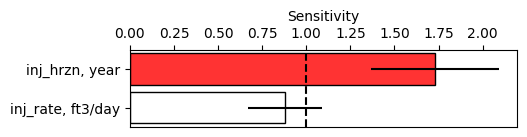

In [103]:
from pyDGSA.plot import vert_pareto_plot

fig, ax = vert_pareto_plot(mean_sensitivity, np_plot='+1', confidence=True)

It's also possible to create a pareto plot of cluster-specific sensitivities, using pre-defined colors for each cluster. Defining the colors is useful for keeping cluster colors consistent across multiple plots

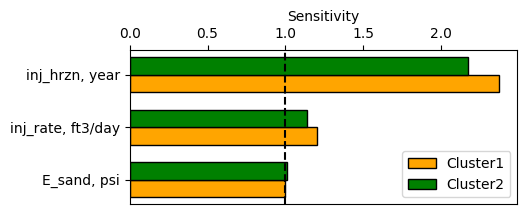

In [104]:
# Define the colors for each cluster
cluster_colors = ['orange', 'green', 'yellow']

# Only plot 3 parameters total to save space (np_plot=3)
fig, ax = vert_pareto_plot(cluster_sensitivity, np_plot=3, fmt='cluster_avg', 
                           colors=cluster_colors)

Next, plot the cdf for parameter `z`, using the same color scheme as the pareto plot above.

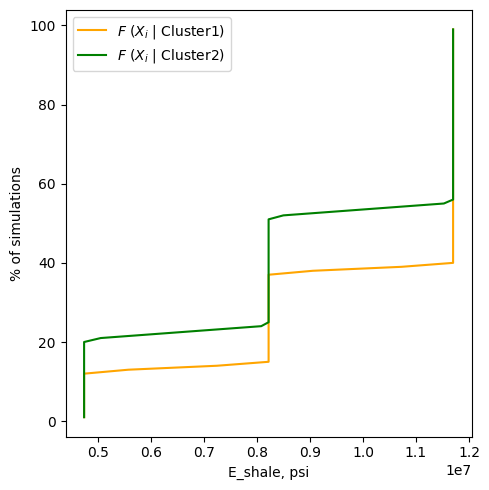

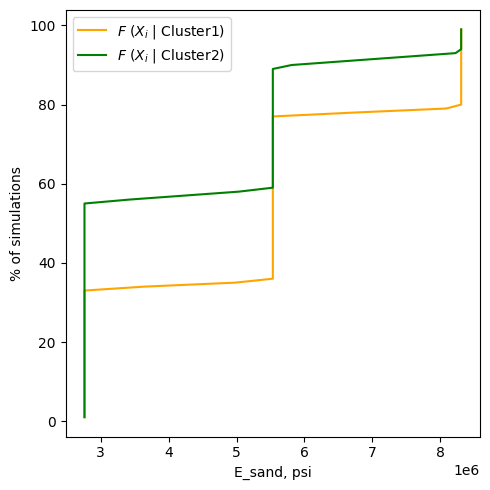

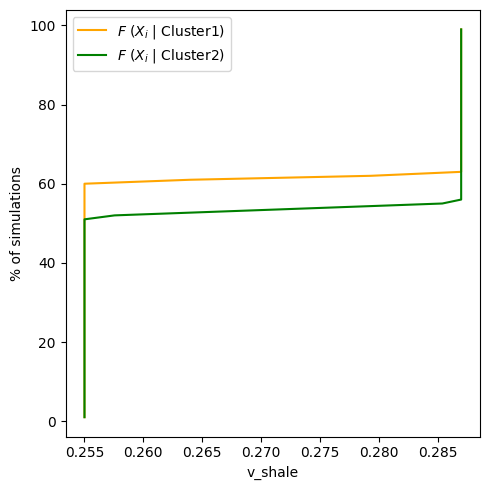

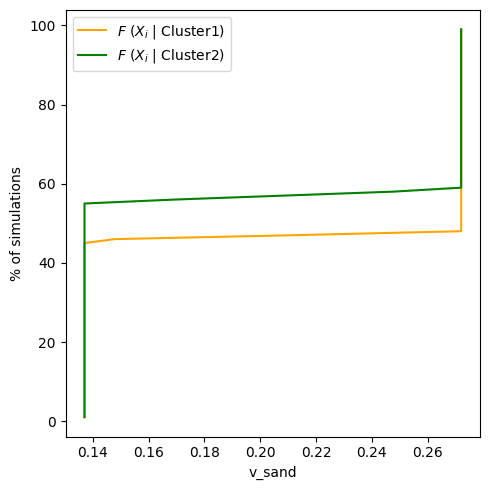

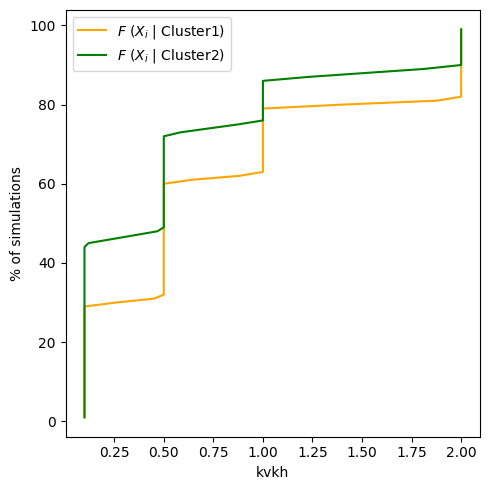

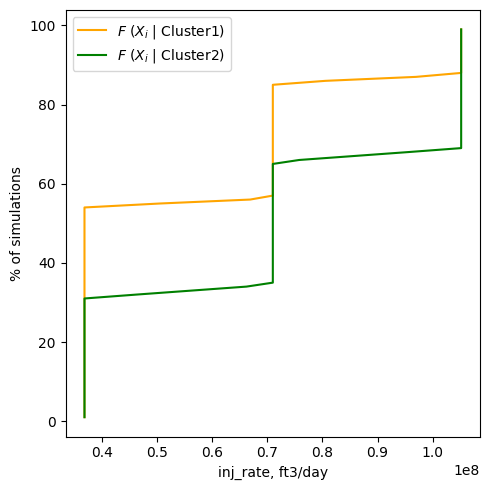

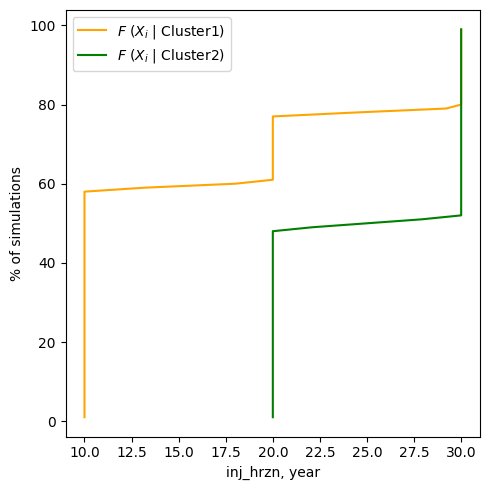

In [105]:
from pyDGSA.plot import plot_cdf

for item in parameter_names:
    fig, ax = plot_cdf(parameters, labels, item, parameter_names=parameter_names, 
                    cluster_names=cluster_names, colors=cluster_colors)

### Plotting response clusters

Next, let's plot the distance between simulations using multidimensional scaling.
This is important, as these distances are the defining feature that control all
other sensitivity calculations.

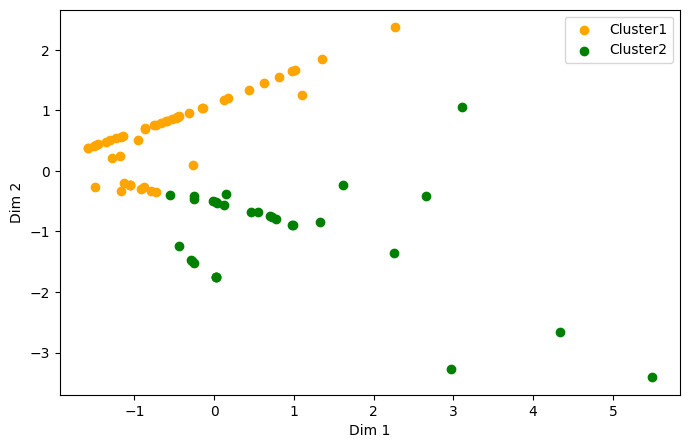

In [106]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Get MDS representation of distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1, normalized_stress=False)
mds_dist = mds.fit_transform(distances)

## Plot mds distances as scatterplot
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
x = mds_dist[:, 0]
y = mds_dist[:, 1]

# Plotting each cluster individually using a for loop,
# though it's possible to plot all clusters at once using
# ax.scatter(x, y, c=[cluster_colors[i] for i in labels])
for i in range(n_clusters):
    sc = ax.scatter(x[labels == i], y[labels == i],
                    c=cluster_colors[i], label=cluster_names[i])
ax.set(xlabel='Dim 1', ylabel='Dim 2')
ax.legend()

### Plotting `dgsa_interactions` results

To display pareto plots of two-way parameter interactions averaged across each cluster and each bin, the options are the same as when plotting `dgsa` results

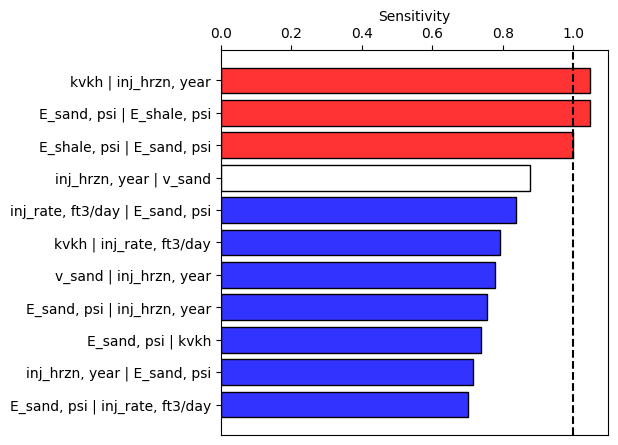

In [107]:
# Only show interactions with sensitivity >= 1 and the next 5 most 
# sensitive interactions (np_plot = '+8')
fig, ax = vert_pareto_plot(mean_interact_sensitivity, np_plot='+8')

Similarly, the options when cluster-specific `dgsa_interactions` results is the same as when plotting cluster-specific `dgsa` results.

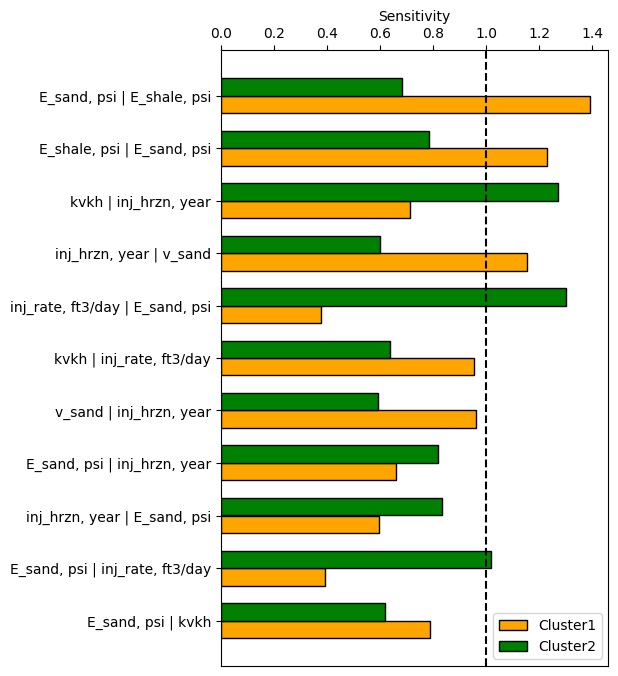

In [108]:
# By default, np_plot = '+5'
fig, ax = vert_pareto_plot(cluster_interact_sensitivity, 
                           fmt='cluster_avg',
                           colors=cluster_colors)

Plot the standardized sensitivity for each bin/cluster combination is also possible. Note that the bars with a bold outline represent those for which the sensitivity >= 1.

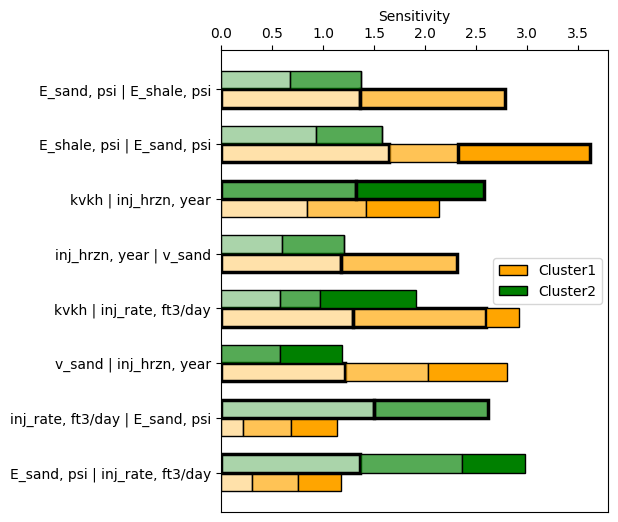

In [109]:
fig, ax = vert_pareto_plot(raw_interact_sensitivity, 
                           fmt='indiv',
                           colors=cluster_colors,
                           np_plot=8)